# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

Нужно собрать данные по клиентам по следующим группам:
1. Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
2. Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
3. Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
4. Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
!pip install shap

     |████████████████████████████████| 997 kB 1.3 MB/s eta 0:00:01


In [2]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

import shap

import warnings

# отключаем предупреждения
warnings.filterwarnings("ignore")

## Загрузка данных

In [3]:
# загружаем файл в виде датафрейма и задаем переменную
data = pd.read_csv('/datasets/market_file.csv')
data.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [4]:
data_money = pd.read_csv('/datasets/market_money.csv')
data_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [5]:
data_time = pd.read_csv('/datasets/market_time.csv')
data_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [6]:
d_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
d_money.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


### Вывод

Данные соответствуют описанию.

## Предобработка данных

In [7]:
data.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропущенных значений нет, изменим типы данных в столбцах с категориями. Сразу проверим на неявные дубликаты.

In [9]:
data['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [10]:
data['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [11]:
# исправим опечатку в "стандартт"
data['Тип сервиса'] = data['Тип сервиса'].replace({'стандартт': 'стандарт'})
data['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [12]:
data['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [13]:
data['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [14]:
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   Покупательская активность            1300 non-null   category
 2   Тип сервиса                          1300 non-null   category
 3   Разрешить сообщать                   1300 non-null   category
 4   Маркет_актив_6_мес                   1300 non-null   float64 
 5   Маркет_актив_тек_мес                 1300 non-null   int64   
 6   Длительность                         1300 non-null   int64   
 7   Акционные_покупки                    1300 non-null   float64 
 8   Популярная_категория                 1300 non-null   category
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  Ошибка_сервиса   

In [15]:
# колонки еще переименую, чтоб красиво было
data = data.rename(columns={
    'Маркет_актив_6_мес': 'Маркет актив 6 мес',
    'Маркет_актив_тек_мес': 'Маркет актив тек мес',
    'Акционные_покупки': 'Акционные покупки',
    'Популярная_категория': 'Популярная категория',
    'Средний_просмотр_категорий_за_визит': 'Средний просмотр категорий за визит',
    'Неоплаченные_продукты_штук_квартал': 'Неоплаченные продукты штук квартал',
    'Ошибка_сервиса': 'Ошибка сервиса',
    'Страниц_за_визит': 'Страниц за визит'
})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   Покупательская активность            1300 non-null   category
 2   Тип сервиса                          1300 non-null   category
 3   Разрешить сообщать                   1300 non-null   category
 4   Маркет актив 6 мес                   1300 non-null   float64 
 5   Маркет актив тек мес                 1300 non-null   int64   
 6   Длительность                         1300 non-null   int64   
 7   Акционные покупки                    1300 non-null   float64 
 8   Популярная категория                 1300 non-null   category
 9   Средний просмотр категорий за визит  1300 non-null   int64   
 10  Неоплаченные продукты штук квартал   1300 non-null   int64   
 11  Ошибка сервиса   

In [16]:
data.duplicated().sum()

0

Типы в порядке, пропущенных значений нет, а дубликатов и подавно, колонки привела к единому виду. Переходим к следующему.

In [17]:
data_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [18]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [19]:
data_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [20]:
data_money['Период'] = data_money['Период'].astype('category')
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       3900 non-null   int64   
 1   Период   3900 non-null   category
 2   Выручка  3900 non-null   float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 65.0 KB


In [21]:
data_money.duplicated().sum()

0

Пропущенных значений нет, неявных дубликатов и явных тоже, поэтому поменяли тип на категорию и смотрим следующий файл.

In [22]:
data_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [23]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [24]:
data_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [25]:
# исправим опечатку
data_time['Период'] = data_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'}).astype('category')
data_time['Период'].unique()

['текущий_месяц', 'предыдущий_месяц']
Categories (2, object): ['текущий_месяц', 'предыдущий_месяц']

In [26]:
data_time.duplicated().sum()

0

In [27]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      2600 non-null   int64   
 1   Период  2600 non-null   category
 2   минут   2600 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 43.4 KB


Пропусков нет, дубликатов тоже. Тип данных поправила, опечатку убрала.

In [28]:
d_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [29]:
d_money.duplicated().sum()

0

## Исследовательский анализ данных

In [30]:
# создадим функции для отображения графиков
def plot_distribution(df, column, bins=30, title=None):
    """
    Функция рисует гистограмму и boxplot для столбца с колличественными данными.
    """
    
    # создаем фигуру с двумя графиками
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # гистограмма
    sns.histplot(df[column], bins=bins, ax=axes[0], kde=True)
    axes[0].set_title(f'Распределение данных "{title}"')
    axes[0].set_xlabel(title)
    axes[0].set_ylabel('Частота')

    # boxplot
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_title(f'Boxplot "{title}"')
    axes[1].set_xlabel(title)

    plt.tight_layout()
    plt.show()

def plot_categorical(df, column, title=None):
    """
    Функция рисует pie chart для столбца с категориальными данными.
    """
    
    # считаем количество для каждой категории
    counts = df[column].value_counts()
    
    plt.figure(figsize=(7, 7))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # чтобы круг был кругом, а не овалом
    plt.show()

def plot_bar_chart(df, column, title, xlab):
    """
    Строит столбчатую диаграмму распределения.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel('Количество пользователей')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

Начнем с первой таблицы data.

In [31]:
# посмотрим какая доля приходится на какую категорию
data['Покупательская активность'].value_counts(normalize=True)

Прежний уровень    0.616923
Снизилась          0.383077
Name: Покупательская активность, dtype: float64

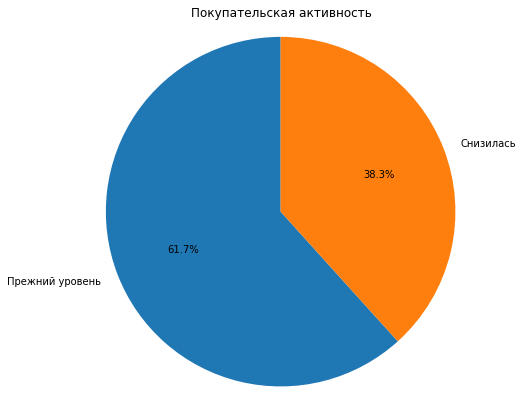

In [32]:
plot_categorical(data, 'Покупательская активность', 'Покупательская активность')

In [33]:
data['Тип сервиса'].value_counts(normalize=True)

стандарт    0.710769
премиум     0.289231
Name: Тип сервиса, dtype: float64

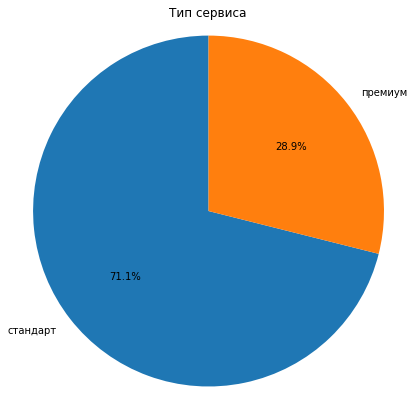

In [34]:
plot_categorical(data, 'Тип сервиса', 'Тип сервиса')

In [35]:
data['Разрешить сообщать'].value_counts(normalize=True)

да     0.74
нет    0.26
Name: Разрешить сообщать, dtype: float64

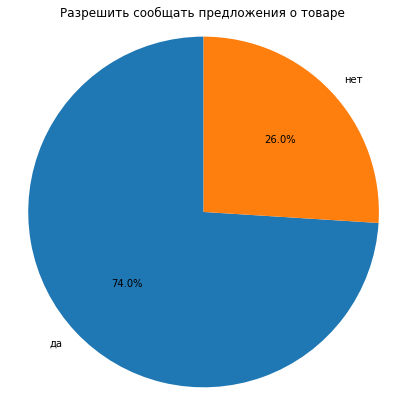

In [36]:
plot_categorical(data, 'Разрешить сообщать', 'Разрешить сообщать предложения о товаре')

In [37]:
data['Популярная категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная категория, dtype: int64

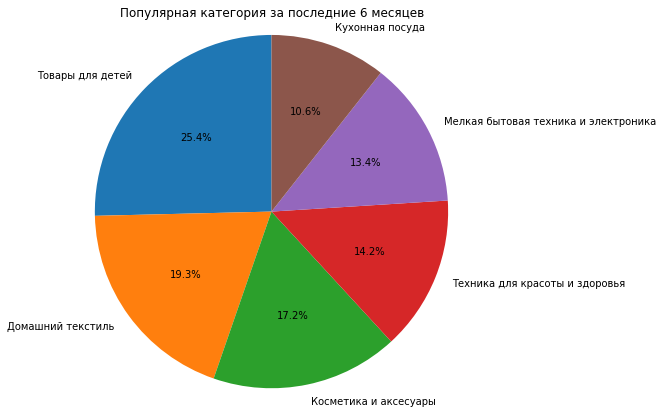

In [38]:
plot_categorical(data, 'Популярная категория', 'Популярная категория за последние 6 месяцев')

In [39]:
data.describe()

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


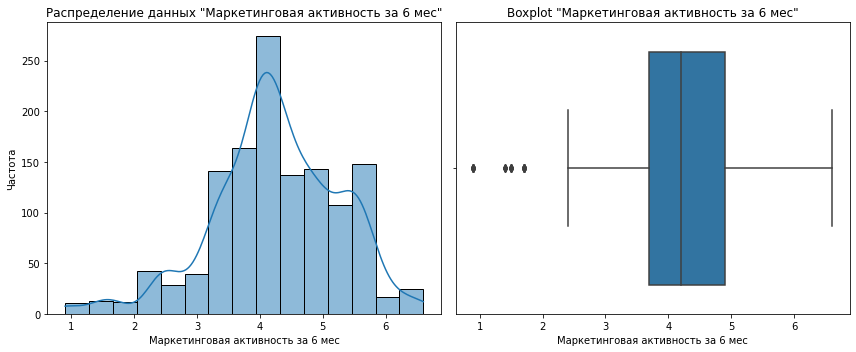

In [40]:
plot_distribution(data,'Маркет актив 6 мес', 15, 'Маркетинговая активность за 6 мес')

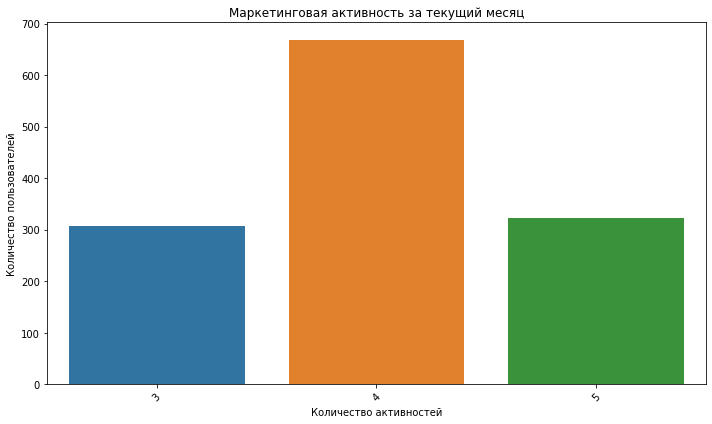

In [41]:
plot_bar_chart(data, 'Маркет актив тек мес', 'Маркетинговая активность за текущий месяц', 'Количество активностей')

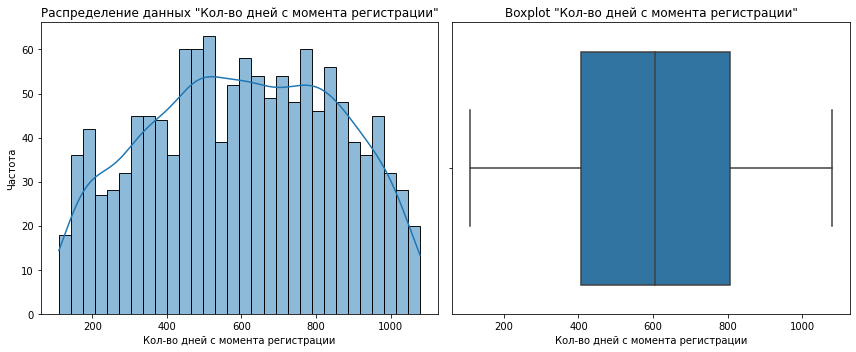

In [42]:
plot_distribution(data, 'Длительность', 30, 'Кол-во дней с момента регистрации')

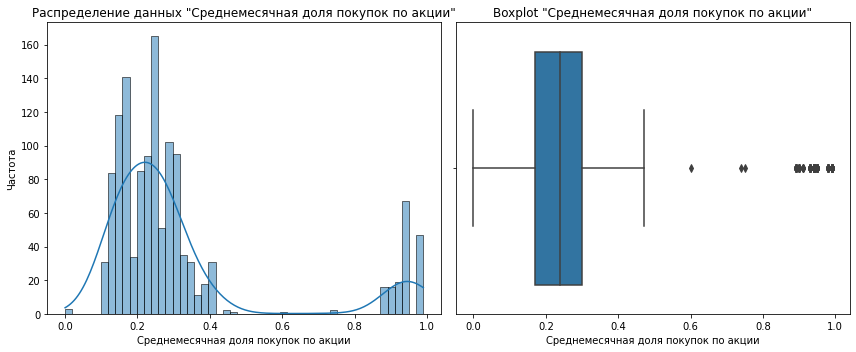

In [43]:
plot_distribution(data, 'Акционные покупки', 50, 'Среднемесячная доля покупок по акции')

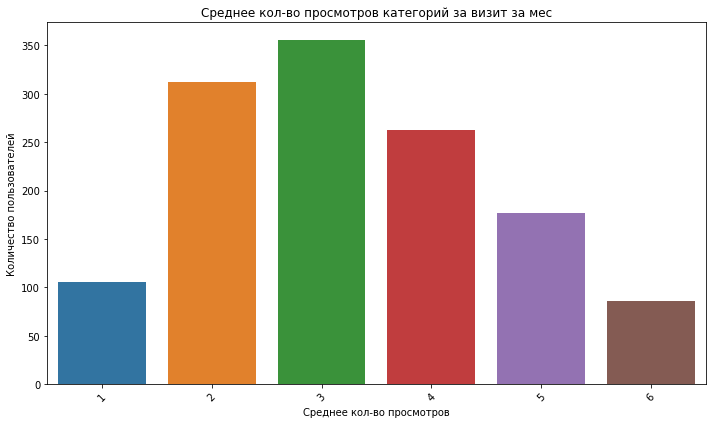

In [44]:
plot_bar_chart(data, 'Средний просмотр категорий за визит', 'Среднее кол-во просмотров категорий за визит за мес', 'Среднее кол-во просмотров')

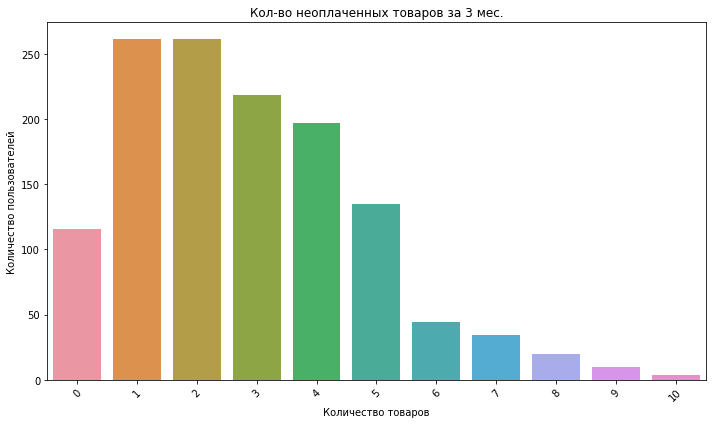

In [47]:
plot_bar_chart(data, 'Неоплаченные продукты штук квартал', 'Кол-во неоплаченных товаров за 3 мес.', 'Количество товаров')

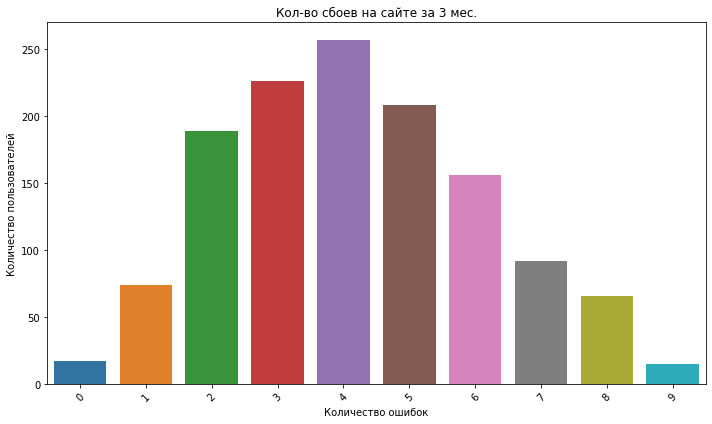

In [46]:
plot_bar_chart(data, 'Ошибка сервиса', 'Кол-во сбоев на сайте за 3 мес.', 'Количество ошибок')

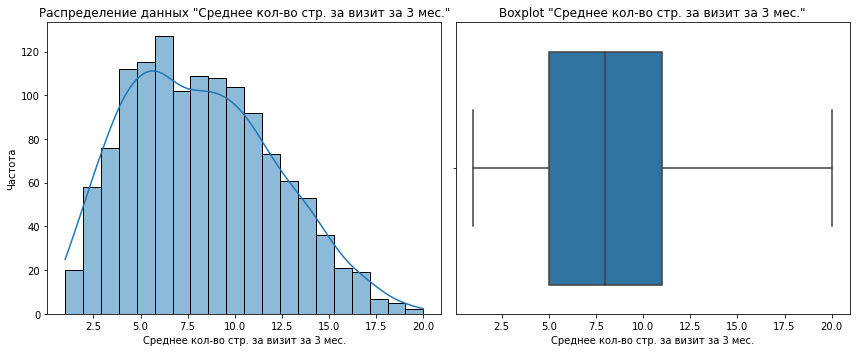

In [47]:
plot_distribution(data, 'Страниц за визит', 20, 'Среднее кол-во стр. за визит за 3 мес.')

#### Выводы

1. Покупательская активность

Большинство клиентов (61,7%) остаются активными, что является положительным сигналом для бизнеса. Однако 38,3% клиентов демонстрируют снижение активности, что требует внимания.

2. Тип сервиса

Большинство клиентов предпочитают стандартный тариф (71,1%), что может быть связано с его доступностью или отсутствием необходимости в дополнительных функциях премиального тарифа. Клиенты премиального тарифа составляют 28,9%.

3. Разрешить сообщать предложения о товаре

Большинство клиентов (74%) готовы получать маркетинговые коммуникации, что открывает возможности для целевых рассылок и уведомлений. Однако 26% клиентов не хотят получать такие сообщения.

4. Популярная категория за последние 6 месяцев

Топ категорий:
- Товары для детей: 25,4%
- Домашний текстиль: 19,3%
- Косметика и аксессуары: 17,2%
- Техника для красоты и здоровья: 14,2%
- Мелкая бытовая техника и электроника: 13,4%
- Кухонная посуда: 10,6%

5. Маркетинговая активность

Среднее число коммуникаций за месяц примерно 4 раза.

6. Дительность использования сервиса

В среднем пользователи зарегистрированы около 1,5 - 2-х лет, есть и те, кто только зарегистрировался, значит сервис все еще востребован и привлекает новых клиентов. Самый преданный покупатель зарегистрирован уже почти 3 года. А самый новенький почти 4 месяца назад, вероятно, стоит обратить внимание на привлечение новых клиентов.

7. Акционные попупки

Средняя доля акционных покупок составляет 24% (лучше ориентироваться на медиану, т.к. есть выбросы). Есть и большие любители акций (99%).

8. Средний просмотр категорий за визит

Среднее из средних около 3 категорий за визит. Минимум 1 страница, то есть что-то просматривают за визит (имею в виду что нет 0).

9. Неоплаченные продукты штук квартал

Среднее количество неоплаченных товаров за квартал около 3х.

10. Ошибка сервиса

Среднее число ошибок сервиса за 3 месяца 4.

11. Страниц за визит

Среднее число просмотров страниц за визит 8.17.

Среднестатистический пользователь такой:

Активный клиент со стандартным тарифом, который зарегистрирован около 2х лет назад. Клиент получает дополнительные предложения о товарах примерно 4 раза в месяц, не особо покупающий по акции. За визит он просматривает 3 страницы из 3х категорий (скорее всего эти категории Товары для детей, Домашний текстиль, Косметика и аксессуары).

### Таблица с данными о выручке, которую получает магазин с покупателя

Посмотрим следующий датасет. Выручка

In [48]:
data_money['Период'].value_counts(normalize=True)

предыдущий_месяц       0.333333
препредыдущий_месяц    0.333333
текущий_месяц          0.333333
Name: Период, dtype: float64

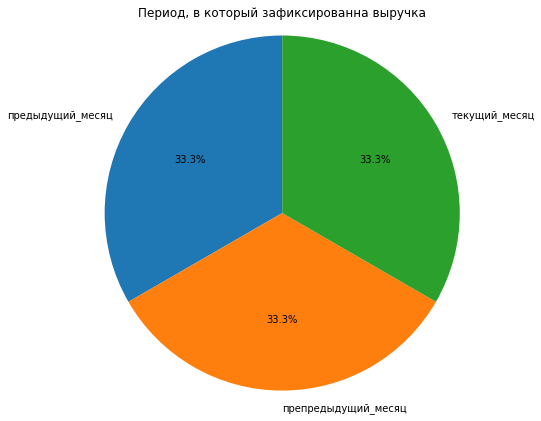

In [49]:
plot_categorical(data_money, 'Период', 'Период, в который зафиксированна выручка')

In [50]:
data_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

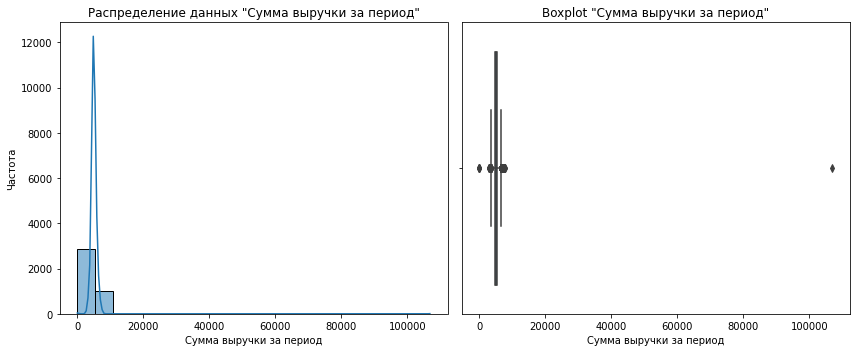

In [51]:
plot_distribution(data_money, 'Выручка', 20, 'Сумма выручки за период')

Ого! Какой выброс, посмотрим внимательнее.

In [52]:
data_money[data_money['Выручка'] > 10000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Не может быть такого, тут скорее всего ошибка в данных, поэтому удалим эту строчку, т.к. она слишком выбивается из данных.

In [53]:
data_money = data_money[data_money['Выручка'] < 10000].reset_index(drop=True)

In [54]:
data_money['Выручка'].describe()

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: Выручка, dtype: float64

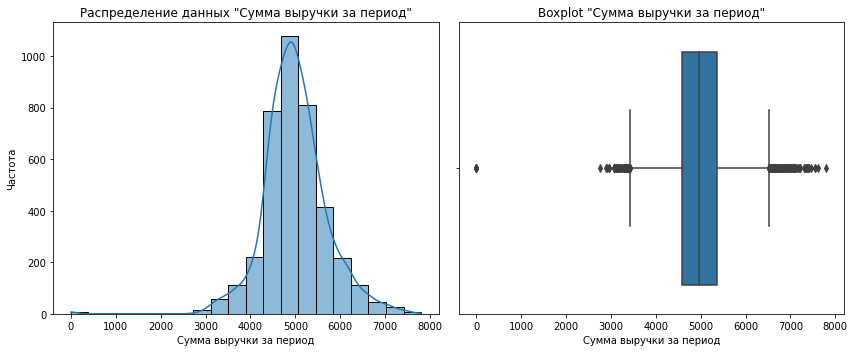

In [55]:
plot_distribution(data_money, 'Выручка', 20, 'Сумма выручки за период')

In [56]:
# посмотрим тех у кого 0 в выручке, воплне вероятно они просто ничего не покупали
data_money[data_money['Выручка'] == 0]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


#### Выводы

Выручка распределена равномерно между 3-мя месяцами 33,3%. Средняя выручка 5000, есть периоды где какие-то клиенты не совершали покупок (таких клиентов всего 3, а в текущий месяц все совершали покупки или же данные не полные).

### Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода

In [57]:
data_time['Период'].value_counts(normalize=True)

предыдущий_месяц    0.5
текущий_месяц       0.5
Name: Период, dtype: float64

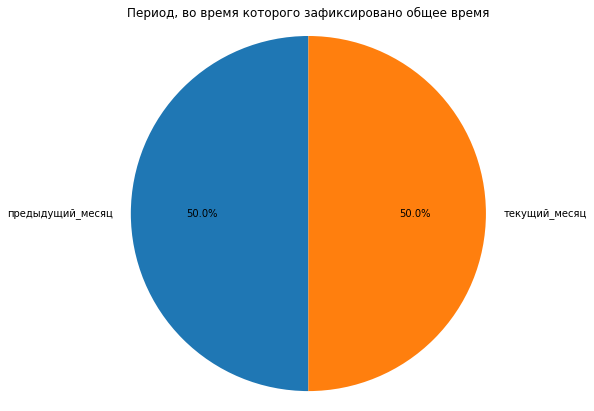

In [58]:
plot_categorical(data_time, 'Период', 'Период, во время которого зафиксировано общее время')

In [59]:
data_time['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

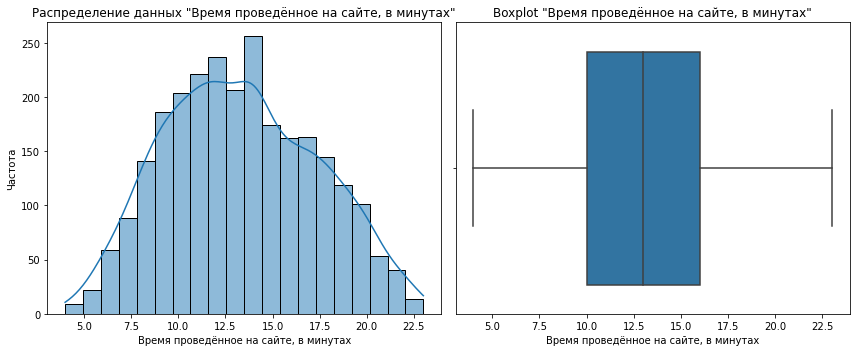

In [60]:
plot_distribution(data_time, 'минут', 20, 'Время проведённое на сайте, в минутах')

#### Выводы

Время, проведенное на сайте, распределено равномерно между текущим и предыдущим месяцем. Среднее время проведенное на сайте 13 мин., минимальное 4 мин., а максимальное 23 мин.

### Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца

In [61]:
d_money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

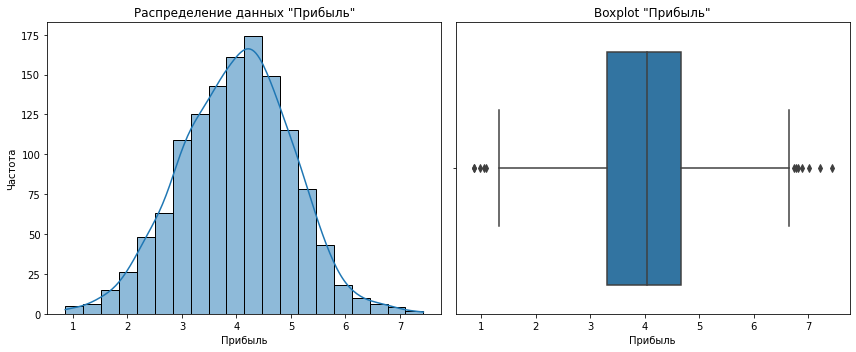

In [62]:
plot_distribution(d_money, 'Прибыль', 20, 'Прибыль')

#### Выводы

Средняя прибыль 4 условных единицы, а большинство клиентов приносят прибыль в диапазоне 3–5 условных единиц

### Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

Будем отбирать клиентов по условию из таблицы data_money, так как там содержится информация по клиенту по выручке в период.

In [63]:
clients = data_money[data_money['Выручка'] > 0].groupby('id')['Период'].count()
clients_3m = clients[clients == 3]
print(f'Найдено клиентов с покупательской активностью не менее трёх месяцев: {clients_3m.count()}')
clients_3m.index.tolist()

Найдено клиентов с покупательской активностью не менее трёх месяцев: 1296


[215349,
 215350,
 215351,
 215352,
 215353,
 215354,
 215355,
 215356,
 215358,
 215360,
 215361,
 215362,
 215363,
 215364,
 215365,
 215366,
 215367,
 215368,
 215369,
 215370,
 215371,
 215372,
 215373,
 215374,
 215375,
 215376,
 215377,
 215378,
 215379,
 215381,
 215382,
 215383,
 215384,
 215385,
 215386,
 215387,
 215388,
 215389,
 215390,
 215391,
 215392,
 215393,
 215394,
 215395,
 215396,
 215397,
 215398,
 215399,
 215400,
 215401,
 215402,
 215403,
 215404,
 215405,
 215406,
 215407,
 215408,
 215409,
 215410,
 215411,
 215412,
 215413,
 215414,
 215415,
 215416,
 215417,
 215418,
 215419,
 215420,
 215421,
 215422,
 215423,
 215424,
 215425,
 215426,
 215427,
 215428,
 215429,
 215430,
 215431,
 215432,
 215433,
 215434,
 215435,
 215436,
 215437,
 215438,
 215439,
 215440,
 215441,
 215442,
 215443,
 215444,
 215445,
 215446,
 215447,
 215448,
 215449,
 215450,
 215451,
 215452,
 215453,
 215454,
 215455,
 215456,
 215457,
 215458,
 215459,
 215460,
 215461,
 215462,
 

#### Вывод

Клиентов, которые имеют покупательскую активность не менее 3х месяцев (то есть все 3 месяца что-то покупали), 1296.

## Объединение таблиц

In [64]:
money_piv = (data_money
    .pivot_table(index='id', columns='Период', values='Выручка', fill_value=0) 
    .add_prefix('Выручка_')
)

time_piv = (data_time 
    .pivot_table(index='id', columns='Период', values='минут', fill_value=0) 
    .add_prefix('Время_')
)
money_piv, time_piv

(Период  Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
 id                                                              
 215348                       0.0                            0   
 215349                    5216.0                         4472   
 215350                    5457.5                         4826   
 215351                    6158.0                         4793   
 215352                    5807.5                         4594   
 ...                          ...                          ...   
 216643                    3664.0                         4704   
 216644                    4729.0                         5299   
 216645                    5160.0                         5334   
 216646                    4923.0                         4725   
 216647                    4720.0                         5183   
 
 Период  Выручка_текущий_месяц  
 id                             
 215348                 3293.1  
 215349                 4971.6  
 215350 

In [65]:
id_3m = clients_3m.index.tolist()

In [66]:
data_final = data.copy()
data_final = data_final[data_final['id'].isin(id_3m)].copy()
print(data.shape)
data_final.shape

(1300, 13)


(1296, 13)

In [67]:
data_final = (data_final.set_index('id')
                   .join(money_piv, how='left')
                   .join(time_piv, how='left')
                   .reset_index()
)

In [68]:
data_final.shape

(1296, 18)

In [69]:
data_final.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124,5388.5,10,10


In [70]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   Покупательская активность            1296 non-null   category
 2   Тип сервиса                          1296 non-null   category
 3   Разрешить сообщать                   1296 non-null   category
 4   Маркет актив 6 мес                   1296 non-null   float64 
 5   Маркет актив тек мес                 1296 non-null   int64   
 6   Длительность                         1296 non-null   int64   
 7   Акционные покупки                    1296 non-null   float64 
 8   Популярная категория                 1296 non-null   category
 9   Средний просмотр категорий за визит  1296 non-null   int64   
 10  Неоплаченные продукты штук квартал   1296 non-null   int64   
 11  Ошибка сервиса   

In [71]:
data_final['Выручка_препредыдущий_месяц'] = data_final['Выручка_препредыдущий_месяц'].astype('float64')
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   Покупательская активность            1296 non-null   category
 2   Тип сервиса                          1296 non-null   category
 3   Разрешить сообщать                   1296 non-null   category
 4   Маркет актив 6 мес                   1296 non-null   float64 
 5   Маркет актив тек мес                 1296 non-null   int64   
 6   Длительность                         1296 non-null   int64   
 7   Акционные покупки                    1296 non-null   float64 
 8   Популярная категория                 1296 non-null   category
 9   Средний просмотр категорий за визит  1296 non-null   int64   
 10  Неоплаченные продукты штук квартал   1296 non-null   int64   
 11  Ошибка сервиса   

## Корреляционный анализ

In [72]:
# выбираем только числовые признаки (int64 и float64), кроме id
numeric_cols = data_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id']
numeric_cols

['Маркет актив 6 мес',
 'Маркет актив тек мес',
 'Длительность',
 'Акционные покупки',
 'Средний просмотр категорий за визит',
 'Неоплаченные продукты штук квартал',
 'Ошибка сервиса',
 'Страниц за визит',
 'Выручка_предыдущий_месяц',
 'Выручка_препредыдущий_месяц',
 'Выручка_текущий_месяц',
 'Время_предыдущий_месяц',
 'Время_текущий_месяц']

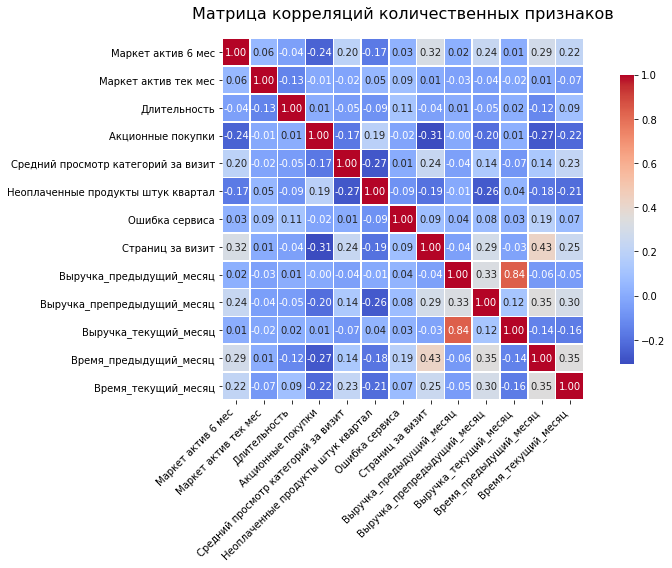

In [73]:
# построим матрицу корреляций
corr_matrix = data_final[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,           # матрица корреляций
    annot=True,            # показывать числа в ячейках
    fmt='.2f',             # округлять до 2 знаков после запятой
    cmap='coolwarm',       # цвет: синий - минус, красный - плюс
    square=True,           # все ячейки квадратные
    cbar=True,             # показать шкалу цветов справа
    cbar_kws={"shrink": .8},  # сделать шкалу чуть короче
    linewidths=0.5         # тонкие линии между ячейками
)
plt.title('Матрица корреляций количественных признаков', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Выводы

Корреляция растет у выручки от месяца:
- умеренная положительная корреляция (0,43) страниц за визит и времени проведенного в предыдущем месяце;
- достаточно высокая положительная корреляция (0,84) между выручкой за текущий месяц и выручкой за предыдущий месяц. 

Это может повлиять на линейные модели, но эти признаки полезны, поэтому оставим.

## Использование пайплайнов

In [74]:
X = data_final.drop(columns=['id', 'Покупательская активность'])
y = data_final['Покупательская активность']

RANDOM_STATE = 42
test_size=0.25

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=RANDOM_STATE,
    stratify=y
)

In [75]:
columns_ohe = ['Разрешить сообщать', 'Популярная категория']
columns_ord = ['Тип сервиса']
num_MMS = X.select_dtypes(include=['float64']).columns.tolist()
num_SS = X.select_dtypes(include=['int64']).columns.tolist()

In [76]:
# пайплайн для OHE
ohe_pipe = Pipeline([
    (
        'imputer_ohe', 
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ohe',
        OneHotEncoder(handle_unknown='ignore', sparse=False)
    )
])

# пайплайн для ORD
ord_pipe = Pipeline([
    (
        'imputer_before_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(
            categories=[['стандарт', 'премиум']],
            handle_unknown='use_encoded_value', unknown_value=np.nan)
    ),
    (
        'imputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])
ohe_pipe, ord_pipe

(Pipeline(steps=[('imputer_ohe', SimpleImputer(strategy='most_frequent')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
 Pipeline(steps=[('imputer_before_ord', SimpleImputer(strategy='most_frequent')),
                 ('ord',
                  OrdinalEncoder(categories=[['стандарт', 'премиум']],
                                 handle_unknown='use_encoded_value',
                                 unknown_value=nan)),
                 ('imputer_after_ord', SimpleImputer(strategy='most_frequent'))]))

In [77]:
# создаём препроцессор
preprocessor = ColumnTransformer([
    ('cat_ord', ord_pipe, columns_ord),
    ('cat_ohe', ohe_pipe, columns_ohe),
    ('num_SS', StandardScaler(), num_SS),
    ('num_MMS', MinMaxScaler(), num_MMS)
], remainder='passthrough')  # на всякий случай, если что-то осталось

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_ord',
                                 Pipeline(steps=[('imputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('imputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Тип сервиса']),
                                ('cat_ohe',...
                                ('num_SS', StandardScaler(),


In [78]:
# итоговый пайплайн
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', 'passthrough')
])

In [79]:
# параметры для RandomizedSearchCV
param_grid = [
    # KNN
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    # Decision Tree
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': [3, 5, 7, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    },
    # Logistic Regression
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'saga']
    },
    # SVC
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True)],  # probability=True для roc_auc
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
    }
]

In [80]:
grid_search = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [81]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_ord',
                                                                         Pipeline(steps=[('imputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(categories=[['стандарт',
                                                                                                                      'премиум']],
                                                                                                         handle_unknown='use_encoded_value',
               

Я выбрала метрику 'f1_macro' потому что есть дисбаланс классов, а данная метрика усреднякет F1-меру по каждому классу отдельно, не учитывая размер класса.

In [82]:
print('Лучшая модель и ее параметры')
print(grid_search.best_estimator_)
print('Метрика лучшей модели', grid_search.best_score_)

Лучшая модель и ее параметры
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ord',
                                                  Pipeline(steps=[('imputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer_after_ord',
                     

In [83]:
# проверим как модель срабовает на тестовых данных
y_pred_train = grid_search.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"F1-macro на тренировочных: {f1_train:.4f}")

F1-macro на тренировочных: 0.8832


In [84]:
# проверим как модель срабовает на тестовых данных
y_pred = grid_search.predict(X_test)
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"F1-macro на тесте: {f1_test:.4f}")

F1-macro на тесте: 0.9013


In [85]:
# проверим модель на адекватность
dummy_clf = DummyClassifier(strategy='prior', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

# Предсказания на тесте
y_dummy_pred = dummy_clf.predict(X_test)

# Метрика
dummy_f1 = f1_score(y_test, y_dummy_pred, average='macro')
print(f"F1-macro у DummyClassifier: {dummy_f1:.4f}")

F1-macro у DummyClassifier: 0.3829


### Вывод

Лучше всего себя показала модель с параметрами: SVC(C=1, gamma='auto', probability=True, random_state=42) (метод опорных векторов).

Метрика (F1-macro) показала неплохой результат: 0.88 на тренировочных и 0,9 на тестовых данных, а при кросс-валидации 0,87.

Оценка адекватности так же показала, что модель справляется значительно лучше, чем наивная константная модель. Ее результат только 0,38.

## Анализ важности признаков

In [86]:
best_model = grid_search.best_estimator_
model = best_model.named_steps['classifier']
preprocessor = best_model.named_steps['preprocessor']

ohe = preprocessor.named_transformers_['cat_ohe'].named_steps['ohe']
ohe_features = ohe.get_feature_names(columns_ohe)

feature_names = np.concatenate([
    columns_ord,
    ohe_features,
    num_SS,
    num_MMS
])
feature_names

array(['Тип сервиса', 'Разрешить сообщать_да', 'Разрешить сообщать_нет',
       'Популярная категория_Домашний текстиль',
       'Популярная категория_Косметика и аксесуары',
       'Популярная категория_Кухонная посуда',
       'Популярная категория_Мелкая бытовая техника и электроника',
       'Популярная категория_Техника для красоты и здоровья',
       'Популярная категория_Товары для детей', 'Маркет актив тек мес',
       'Длительность', 'Средний просмотр категорий за визит',
       'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
       'Страниц за визит', 'Время_предыдущий_месяц',
       'Время_текущий_месяц', 'Маркет актив 6 мес', 'Акционные покупки',
       'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
       'Выручка_текущий_месяц'], dtype=object)

In [87]:
X_sample = X.sample(50, random_state=RANDOM_STATE)
X_processed = preprocessor.transform(X_sample)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
X_processed_df.head()

,Тип сервиса,Разрешить сообщать_да,Разрешить сообщать_нет,Популярная категория_Домашний текстиль,Популярная категория_Косметика и аксесуары,Популярная категория_Кухонная посуда,Популярная категория_Мелкая бытовая техника и электроника,Популярная категория_Техника для красоты и здоровья,Популярная категория_Товары для детей,Маркет актив тек мес,...,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,Время_предыдущий_месяц,Время_текущий_месяц,Маркет актив 6 мес,Акционные покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.380136,...,-0.927589,-0.099707,-0.051028,-0.647600,-0.064910,0.526316,0.159091,0.561503,0.202556,0.617117
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.034940,...,3.024703,-0.615212,-1.316315,-0.393270,-0.784593,0.456140,0.886364,0.138460,0.211502,0.151090
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.034940,...,0.060484,-1.130716,-0.051028,0.369721,-1.744172,0.719298,0.181818,0.619048,0.237700,0.692463
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.034940,...,0.060484,0.415798,2.479546,-0.138940,-2.223961,0.578947,0.136364,0.678980,0.912460,0.599222
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.380136,...,0.554520,0.931303,0.202029,1.641373,-0.304804,0.701754,0.909091,0.736525,0.761661,0.724602


In [88]:
explainer = shap.Explainer(model.predict_proba, X_processed_df)
shap_values = explainer(X_processed_df)

PermutationExplainer explainer: 51it [00:29,  1.38it/s]                        


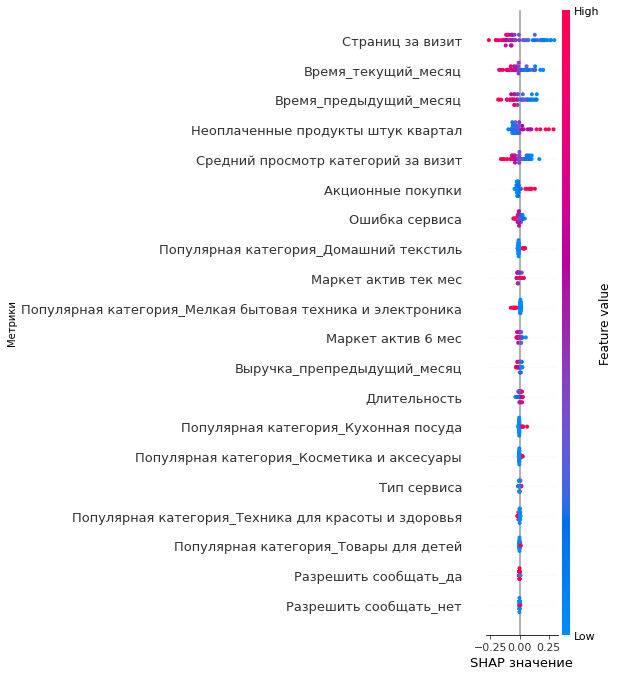

In [89]:
shap.summary_plot(shap_values[:, :, 1], feature_names=feature_names, show=False)

plt.xlabel("SHAP значение")
plt.ylabel("Метрики")
plt.show()

### Вывод

1. Признаки с высоким влиянием (определяющие признаки). Эти признаки расположены в верхней части графика, что указывает на их высокий средний абсолютный SHAP value. Широкий разброс говорит о том, что эти признаки сильно зависят от конкретных значений и могут иметь разное влияние в зависимости от ситуации.
- Страниц за визит.
- Время текущий месяц.
- Время предыдущий месяц.
- Неоплаченные продукты штук квартал.
- Средний просмотр категорий за визит.
- Акционные покупки.
2. Признаки с умеренным влиянием. Эти признаки расположены в средней части графика и имеют средний разброс.
- Ошибка сервиса.
- Популярная категория_Домашний текстиль.
- Маркет актив тек мес.
- Популярная категория_Мелкая бытовая техника и электроника.
- Маркет актив 6 мес.
- Выручка препредыдущий месяц.
- Длительность.
- Популярная категория_Кухонная посуда.
3. Признаки с низким влиянием. Эти признаки расположены в нижней части графика и разброс SHAP values у этих признаков минимальный, что говорит о том, что они практически не влияют на изменение целевой переменной.
- Остальные.

При принятии бизнес-решений стоит:
1. Увеличить кол-во контента, например, рекомендаций. Также стоит обратить внимание на то что мы показываем (контент), чтобы показывать более интересные рекомендации для каждого пользователя.
2. Организовать регулярные акции/специальные предложения или распродажи. Это может удержать пользователей.

Эти пункты тесно связаны с определяющими признаками, поэтому на них стоит обратить внимание. Они таже повлияют на признаки с умеренным влиянием, что только поможет в дальнейшей работе.

## Сегментация покупателей

Чтобы сфокусироваться на 2х важных вещах для бизнеса: прибыльность и риск снижения активности, мы выберем 4 сегмента пользователей:
1. Стабильные клиенты. Низкий риск ухода (снижения активности), высокая прибыльность.
2. Потенциальные клиенты. Низкий риск ухода (снижения активности), низкая прибыльность.
3. Ключевые клиенты. Высокий риск ухода (снижения активности), высокая прибыльность.
4. Уходящие клиенты. Высокий риск ухода (снижения активности), низкая прибыльность.

Особое внимание нужно будет уделить "ключевым" (поэтому такое название) у них высокий риск ухода из сервиса, но высокие траты, которые не хочется потерять.

А также в зависимости от категории, в которую попадет клиент, можно будет подобрать персональные предложения, например:
1. Для стабильного клиента - цель предложений будет углубить лояльность.
2. Для потенциального клиента - цель предложений - это стимулировать рост.
3. Для ключевых клиентов - цель будет удержать.
4. Для уходящих клиентов - минимизировать затраты и распределить их на другие сегменты. Либо же если не хочется терять таких клиентов, то для них нужен будет комплекс мероприятий по стимулированию роста покупок и удержанию этих клиентов.

In [90]:
# функция создания сегментов
def assign_segment(row):
    if row['Оценка риска'] >= high_risk and row['Прибыль'] >= high_profit:
        return 'Ключевые клиенты'
    elif row['Оценка риска'] < high_risk and row['Прибыль'] >= high_profit:
        return 'Стабильные клиенты'
    elif row['Оценка риска'] < high_risk and row['Прибыль'] < high_profit:
        return 'Потенциальные клиенты'
    else:
        return 'Уходящие клиенты'

In [91]:
df_full = data_final.merge(d_money, on='id', how='inner')
df_full.shape

(1296, 19)

In [92]:
df_full.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95


In [93]:
# вероятность снижения активности из лучшей модели
probabilities = best_model.predict_proba(X)[:, 1]
df_full['Оценка риска'] = probabilities
df_full.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Прибыль,Оценка риска
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,0.917663
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13,0.796381
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87,0.617602
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,0.983590
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95,0.924374


In [94]:
df_full.describe()

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Прибыль,Оценка риска
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,215999.464506,4.256404,4.009259,602.967593,0.320069,3.267747,2.841821,4.184414,8.187500,4947.468750,4836.202160,5238.096065,13.470679,13.210648,3.997701,0.380159
std,374.327860,1.013525,0.696316,249.195823,0.249159,1.355125,1.974074,1.951719,3.978459,700.797239,333.514091,834.318717,3.937630,4.221794,1.011198,0.381332
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000,0.860000,0.012407
25%,215675.750000,3.700000,4.000000,409.500000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.125000,4584.500000,4706.050000,10.750000,10.000000,3.300000,0.077399
50%,215999.500000,4.200000,4.000000,606.500000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4810.500000,5179.950000,13.000000,13.000000,4.045000,0.144832
75%,216323.250000,4.900000,4.000000,806.250000,0.300000,4.000000,4.000000,6.000000,11.000000,5405.625000,5056.000000,5759.275000,17.000000,16.000000,4.670000,0.887361
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000,7.430000,1.000000


In [95]:
# возьмем медиану (порог)
high_risk = df_full['Оценка риска'].median()
high_profit = df_full['Прибыль'].median()

# создаем сегменты
df_full['Сегмент'] = df_full.apply(assign_segment, axis=1)
df_full['Сегмент'].value_counts()

Уходящие клиенты         325
Стабильные клиенты       325
Потенциальные клиенты    323
Ключевые клиенты         323
Name: Сегмент, dtype: int64

In [96]:
# выведем сводную с данными по сегментам
segment_stats = df_full.groupby('Сегмент').agg(
    count=('id', 'size'),
    avg_risk=('Оценка риска', 'mean'),
    avg_revenue=('Прибыль', 'mean'),
    total_revenue=('Прибыль', 'sum'),
    share_of_total=('Прибыль', lambda x: (x.sum() / df_full['Прибыль'].sum()) * 100)
).round(2)

segment_stats

,count,avg_risk,avg_revenue,total_revenue,share_of_total
Сегмент,,,,,
Ключевые клиенты,323,0.68,4.78,1544.52,29.81
Потенциальные клиенты,323,0.08,3.21,1035.64,19.99
Стабильные клиенты,325,0.08,4.83,1569.46,30.29
Уходящие клиенты,325,0.67,3.17,1031.40,19.91


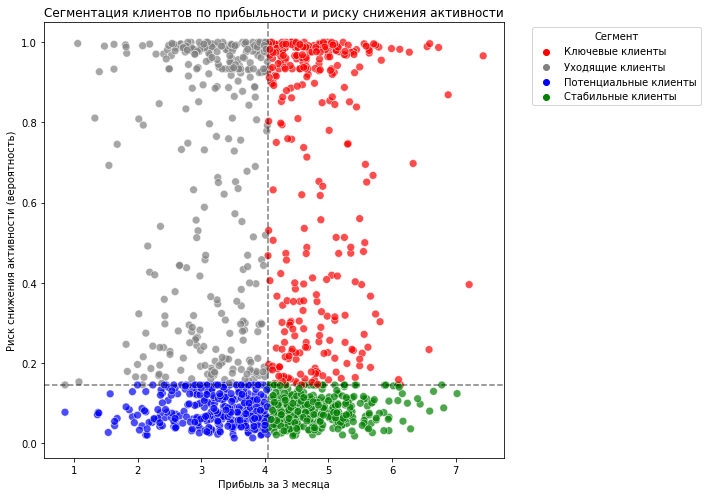

In [97]:
# нарисуем график
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_full,
    x='Прибыль',
    y='Оценка риска',
    hue='Сегмент',
    palette={
        'Стабильные клиенты': 'green',
        'Потенциальные клиенты': 'blue',
        'Ключевые клиенты': 'red',
        'Уходящие клиенты': 'gray'
    },
    alpha=0.7,
    s=60
)
plt.axvline(high_profit, color='k', linestyle='--', alpha=0.5)
plt.axhline(high_risk, color='k', linestyle='--', alpha=0.5)
plt.title('Сегментация клиентов по прибыльности и риску снижения активности')
plt.xlabel('Прибыль за 3 месяца')
plt.ylabel('Риск снижения активности (вероятность)')
plt.legend(title='Сегмент', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Вывод и предложения

Ключевые клиенты (на графике справа вверху, красным цветом):
- средний риск ухода 0,68;
- средняя прибыльность 4,78 у.е.;
- значительная доля в общей выручке - 29.81%.

Это сегмент высокого риска ухода, который приносит большую часть дохода.

Как я уже писала выше, в данном сегменту наша цель удержать клиентов. Поэтому предлагаю:
1. Создать или доработать алгоритм рекомендаций на основе профилей покупок. Это даст нам персонализированные рекомендации, что повысит лояльность и увеличит продажи, за счет показа новых продуктов в рекомендациях.
2. Ввести программу лояльности. Например, дополнительную рассылку с промокодом или бонус. Можно также создать специальную программу лояльности с увеличенными бонусами (это может быть и бесплатная доставка при заказе от фиксированной суммы, баллы, доп акции специальные для участников программы). Как видели на графике, акционные покупки сильно влияют на показатель риска снижения активности.
3. Провести допольнительные опросы или созвоны, чтобы понять причины снижения активности. Чтобы повысить кол-во пройденных опросов, так же можно предложить бонусы по завершению. Это поможет понять что стоит улучшить или доработать, а телефонный разговор с менеджером покажет и заинтересованность компании/сервиса в улучшениях и окажет внимание клиентам.

## Общий вывод

### Загрузка данных

Было загружено 4 файла, данные соответсвуют описанию.

### Предобработка данных

Пропущенных значений не было, были доработаны опечатки и убраны неявные дубликаты в значениях.

### Исследовательский анализ данных

1. Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
**Покупательская активность**

Большинство клиентов (61,7%) остаются активными, что является положительным сигналом для бизнеса. Однако 38,3% клиентов демонстрируют снижение активности, что требует внимания.

**Тип сервиса**

Большинство клиентов предпочитают стандартный тариф (71,1%), что может быть связано с его доступностью или отсутствием необходимости в дополнительных функциях премиального тарифа. Клиенты премиального тарифа составляют 28,9%.

**Разрешить сообщать предложения о товаре**

Большинство клиентов (74%) готовы получать маркетинговые коммуникации, что открывает возможности для целевых рассылок и уведомлений. Однако 26% клиентов не хотят получать такие сообщения.

**Популярная категория за последние 6 месяцев**

Топ категорий:
- Товары для детей: 25,4%
- Домашний текстиль: 19,3%
- Косметика и аксессуары: 17,2%
- Техника для красоты и здоровья: 14,2%
- Мелкая бытовая техника и электроника: 13,4%
- Кухонная посуда: 10,6%

**Маркетинговая активность**

Среднее число коммуникаций за месяц примерно 4 раза.

**Дительность использования сервиса**

В среднем пользователи зарегистрированы около 1,5 - 2-х лет, есть и те, кто только зарегистрировался, значит сервис все еще востребован и привлекает новых клиентов. Самый преданный покупатель зарегистрирован уже почти 3 года. А самый новенький почти 4 месяца назад, вероятно, стоит обратить внимание на привлечение новых клиентов.

**Акционные попупки**

Средняя доля акционных покупок составляет 24% (лучше ориентироваться на медиану, т.к. есть выбросы). Есть и большие любители акций (99%).

**Средний просмотр категорий за визит**

Среднее из средних около 3 категорий за визит. Минимум 1 страница, то есть что-то просматривают за визит (имею в виду что нет 0).

**Неоплаченные продукты штук квартал**

Среднее количество неоплаченных товаров за квартал около 3х.

**Ошибка сервиса**

Среднее число ошибок сервиса за 3 месяца 4.

**Страниц за визит**

Среднее число просмотров страниц за визит 8.17.

Среднестатистический пользователь такой:

Активный клиент со стандартным тарифом, который зарегистрирован около 2х лет назад. Клиент получает дополнительные предложения о товарах примерно 4 раза в месяц, не особо покупающий по акции. За визит он просматривает 3 страницы из 3х категорий (скорее всего эти категории Товары для детей, Домашний текстиль, Косметика и аксессуары).

2. Таблица с данными о выручке, которую получает магазин с покупателя

Выручка распределена равномерно между 3-мя месяцами 33,3%. Средняя выручка 5000, есть периоды где какие-то клиенты не совершали покупок (таких клиентов всего 3, а в текущий месяц все совершали покупки или же данные не полные).

3. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода

Время, проведенное на сайте, распределено равномерно между текущим и предыдущим месяцем. Среднее время проведенное на сайте 13 мин., минимальное 4 мин., а максимальное 23 мин.

4. Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца

Средняя прибыль 4 условных единицы, а большинство клиентов приносят прибыль в диапазоне 3–5 условных единиц

5. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

Клиентов, которые имеют покупательскую активность не менее 3х месяцев (то есть все 3 месяца что-то покупали), 1296.

### Объединение таблиц и корреляционный анализ

Были объеденены 3 таблицы: market_file.csv, market_money.csv, market_time.csv. Для дальнейшей работы.

Корреляция растет у выручки от месяца:
- умеренная положительная корреляция (0,43) страниц за визит и времени проведенного в предыдущем месяце;
- достаточно высокая положительная корреляция (0,84) между выручкой за текущий месяц и выручкой за предыдущий месяц. 

Это может повлиять на линейные модели, но эти признаки полезны, поэтому оставим.

### Использование пайплайнов

На обснове объединенной таблицы создан пайплайн для поиска лучшей модели для предсказания снижения активности пользователей.

Лучше всего себя показала модель с параметрами: SVC(C=1, gamma='auto', probability=True, random_state=42) (метод опорных векторов).

Метрика (F1-macro) показала неплохой результат: 0.88 на тренировочных и 0,9 на тестовых данных, а при кросс-валидации 0,87.

Оценка адекватности так же показала, что модель справляется значительно лучше, чем наивная константная модель. Ее результат только 0,38.

### Анализ важности признаков

1. Признаки с высоким влиянием (определяющие признаки). Эти признаки расположены в верхней части графика, что указывает на их высокий средний абсолютный SHAP value. Широкий разброс говорит о том, что эти признаки сильно зависят от конкретных значений и могут иметь разное влияние в зависимости от ситуации.
- Страниц за визит.
- Время текущий месяц.
- Время предыдущий месяц.
- Неоплаченные продукты штук квартал.
- Средний просмотр категорий за визит.
- Акционные покупки.
2. Признаки с умеренным влиянием. Эти признаки расположены в средней части графика и имеют средний разброс.
- Ошибка сервиса.
- Популярная категория_Домашний текстиль.
- Маркет актив тек мес.
- Популярная категория_Мелкая бытовая техника и электроника.
- Маркет актив 6 мес.
- Выручка препредыдущий месяц.
- Длительность.
- Популярная категория_Кухонная посуда.
3. Признаки с низким влиянием. Эти признаки расположены в нижней части графика и разброс SHAP values у этих признаков минимальный, что говорит о том, что они практически не влияют на изменение целевой переменной.
- Остальные.

При принятии бизнес-решений стоит:
1. Увеличить кол-во контента, например, рекомендаций. Также стоит обратить внимание на то что мы показываем (контент), чтобы показывать более интересные рекомендации для каждого пользователя.
2. Организовать регулярные акции/специальные предложения или распродажи. Это может удержать пользователей.

Эти пункты тесно связаны с определяющими признаками, поэтому на них стоит обратить внимание. Они таже повлияют на признаки с умеренным влиянием, что только поможет в дальнейшей работе.

### Сегментация покупателей

Чтобы сфокусироваться на 2х важных вещах для бизнеса: прибыльность и риск снижения активности, мы выберем 4 сегмента пользователей:
1. Стабильные клиенты. Низкий риск ухода (снижения активности), высокая прибыльность.
2. Потенциальные клиенты. Низкий риск ухода (снижения активности), низкая прибыльность.
3. Ключевые клиенты. Высокий риск ухода (снижения активности), высокая прибыльность.
4. Уходящие клиенты. Высокий риск ухода (снижения активности), низкая прибыльность.

Особое внимание нужно будет уделить "ключевым" (поэтому такое название) у них высокий риск ухода из сервиса, но высокие траты, которые не хочется потерять.

А также в зависимости от категории, в которую попадет клиент, можно будет подобрать персональные предложения, например:
1. Для стабильного клиента - цель предложений будет углубить лояльность.
2. Для потенциального клиента - цель предложений - это стимулировать рост.
3. Для ключевых клиентов - цель будет удержать.
4. Для уходящих клиентов - минимизировать затраты и распределить их на другие сегменты. Либо же если не хочется терять таких клиентов, то для них нужен будет комплекс мероприятий по стимулированию роста покупок и удержанию этих клиентов.

**Вывод и предложения**

Ключевые клиенты (на графике справа вверху, красным цветом):
- средний риск ухода 0,68;
- средняя прибыльность 4,78 у.е.;
- значительная доля в общей выручке - 29.81%.

Это сегмент высокого риска ухода, который приносит большую часть дохода.

Как я уже писала выше, в данном сегменту наша цель удержать клиентов. Поэтому предлагаю:
1. Создать или доработать алгоритм рекомендаций на основе профилей покупок. Это даст нам персонализированные рекомендации, что повысит лояльность и увеличит продажи, за счет показа новых продуктов в рекомендациях.
2. Ввести программу лояльности. Например, дополнительную рассылку с промокодом или бонус. Можно также создать специальную программу лояльности с увеличенными бонусами (это может быть и бесплатная доставка при заказе от фиксированной суммы, баллы, доп акции специальные для участников программы). Как видели на графике, акционные покупки сильно влияют на показатель риска снижения активности.
3. Провести допольнительные опросы или созвоны, чтобы понять причины снижения активности. Чтобы повысить кол-во пройденных опросов, так же можно предложить бонусы по завершению. Это поможет понять что стоит улучшить или доработать, а телефонный разговор с менеджером покажет и заинтересованность компании/сервиса в улучшениях и окажет внимание клиентам.